In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from plot_functions import plot_predictions, plot_decision_boundary

import torch
from torch import nn # PyTorch's building blocks for neural networks

torch.__version__

'2.3.1'

<br>
<br>

# 1. Preparing the dataset

In [6]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=1000,
                  n_features=2, # number of features
                  centers=4, # number of classes(clusters)
                  cluster_std=1.5, # 동일 클러스터 내의 데이터들을 흩어뜨리는 정도
                  random_state=42)

print(X[:5], '\n\n', y[:5])

[[-8.41339595  6.93516545]
 [-5.76648413 -6.43117072]
 [-6.04213682 -6.76610151]
 [ 3.95083749  0.69840313]
 [ 4.25049181 -0.28154475]] 

 [3 2 2 1 1]


#### PyTorch multi-class 분류 시에는 target 데이터를 **2차원 행렬로 만들거나 one-hot encoding을 적용해줄 필요가 없습니다**. 

In [60]:
# y = y.reshape(-1, 1) # 이진분류 시에만 필요

# print(y[:5])

In [7]:
# Numpy array -> PyTorch tensor

X = torch.from_numpy(X).type(torch.float) # Numpy"로부터" & torch.float == float32
y = torch.from_numpy(y).type(torch.LongTensor) # IntTensor == Int32 vs LongTensor == Int64

print(X[:5], '\n\n', y[:5])

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) 

 tensor([3, 2, 2, 1, 1])


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=42) 

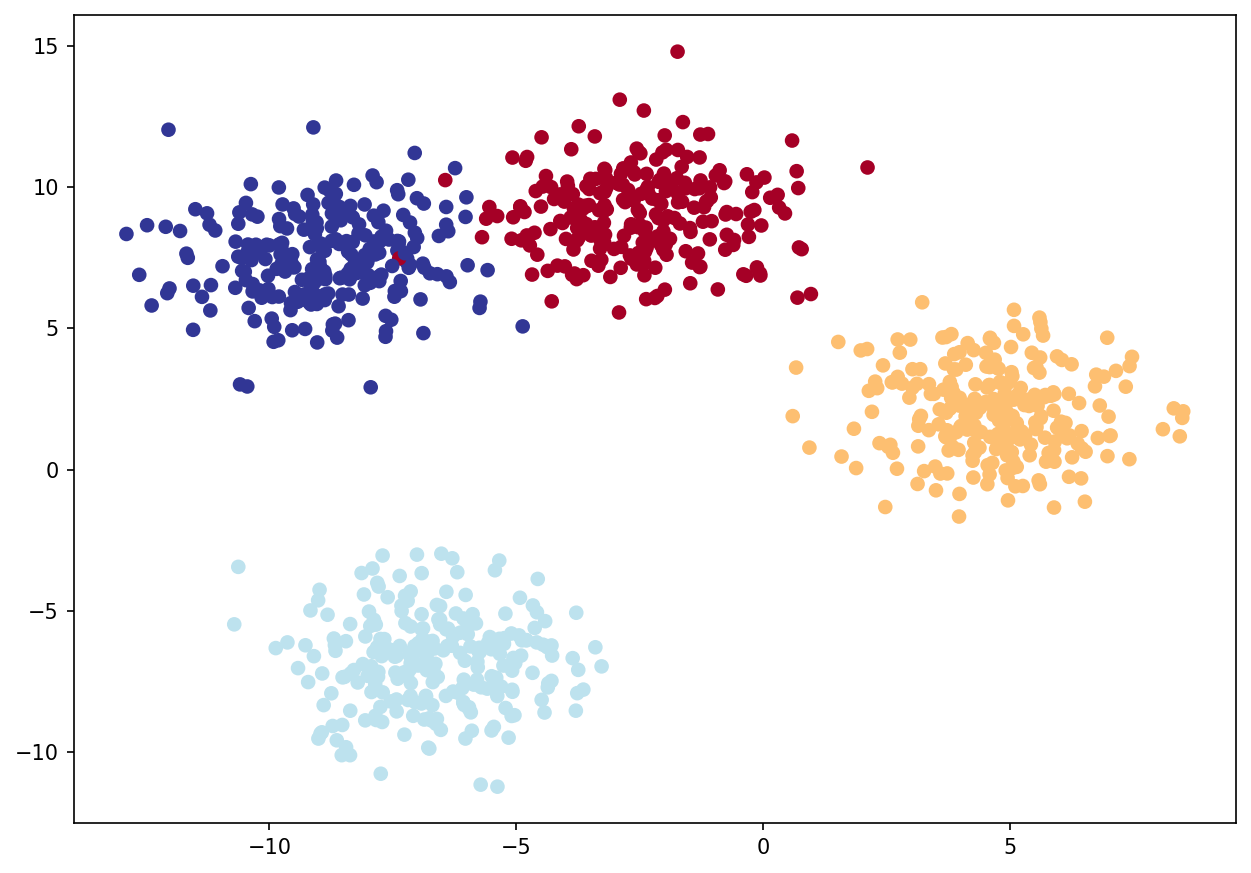

In [10]:
plt.figure(figsize=(10, 7), dpi=150) # dots per inch

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='RdYlBu') # Matplotlib color-map

plt.show()

<br>
<br>

# 2. Build the model (Multi-class classification)

<br>

## Pytorch Cheet sheet @ https://pytorch.org/tutorials/beginner/ptcheat.html

<br>
<br>

### 1) Build the model

In [11]:
device = "mps" if torch.backends.mps.is_available() else "cpu" # "cuda"가 사용 가능하다면(if it "is available")

device

'mps'

In [12]:
class ModelBlobMLP(nn.Module):
    
    
    def __init__(self, num_features, num_classes, num_nodes=16):
        
        super().__init__()
        
        self.sequential_stack = nn.Sequential( # Make a sequential model
            
            nn.Linear(in_features=num_features, out_features=num_nodes),
            # nn.ReLU(), # apply as needed (Non-linearity)
            
            nn.Linear(in_features=num_nodes, out_features=num_nodes),
            # nn.ReLU(), # apply as needed (Non-linearity)
            
            nn.Linear(in_features=num_nodes, out_features=num_classes), # num_classes != number of columns in target
            # We don't need to use nn.Softmax() (check the following source codes)
        )
    
    def forward(self, x): # forward-pass
        
        return self.sequential_stack(x)

In [13]:
torch.manual_seed(42) # "Manually" set the "seed" for [ nn.Parameter ]

model = ModelBlobMLP(num_features=2, # X.shape[1]
                     num_classes=4,  # len(y.unique())
                     num_nodes=16).to(device) # 특정한 디바이스"로"

model

ModelBlobMLP(
  (sequential_stack): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=16, bias=True)
    (2): Linear(in_features=16, out_features=4, bias=True)
  )
)

<br>
<br>

### 2) Check the model

In [14]:
# 모델을 evaluation mode로 설정
model.eval()

with torch.inference_mode(): # Set "inference mode"
    
    # (x 데이터를 모델에 넣고) 순방향 계산 진행 (forward pass)
    untrained_logits = model(X_test.to(device)) # 모델 & 데이터는 동일한 디바이스 위에 위치해있어야 함

<br>

### logits

In [15]:
print(len(untrained_logits))
print(len(y_test))

print(untrained_logits[:10]) # Number of classes == 4

300
300
tensor([[-0.5587,  0.7304,  1.5473, -0.1164],
        [-0.7560, -0.9584, -3.6676, -0.0927],
        [ 0.7154, -0.2835, -2.4023, -0.4896],
        [-0.2235,  0.7073,  1.2775, -0.2100],
        [-1.1116, -0.0583, -0.6173,  0.0229],
        [-0.8489, -1.2133, -4.4177, -0.0716],
        [ 0.7836, -0.0246, -1.6251, -0.5038],
        [-0.9913, -0.2824, -1.3955, -0.0147],
        [ 0.6917, -0.6680, -3.6021, -0.4901],
        [-1.0178, -0.1914, -1.0927, -0.0057]], device='mps:0')


<br>

### probabilities (use "**torch.softmax**")

In [16]:
untrained_probs = torch.softmax(untrained_logits, dim=1) # dim=1 : 행 방향 연산 (dimension 1)

print(untrained_probs[:10]) # Number of classes == 4

tensor([[0.0694, 0.2520, 0.5705, 0.1081],
        [0.2623, 0.2142, 0.0143, 0.5092],
        [0.5840, 0.2151, 0.0258, 0.1750],
        [0.1107, 0.2807, 0.4965, 0.1122],
        [0.1161, 0.3328, 0.1903, 0.3609],
        [0.2565, 0.1782, 0.0072, 0.5581],
        [0.5520, 0.2460, 0.0496, 0.1523],
        [0.1574, 0.3197, 0.1050, 0.4179],
        [0.6341, 0.1628, 0.0087, 0.1945],
        [0.1436, 0.3281, 0.1332, 0.3951]], device='mps:0')


In [17]:
sum(untrained_probs[0]) # .item()

tensor(1.0000, device='mps:0')

<br>

### probabilities (use "**torch.argmax**")

In [18]:
print(untrained_probs[:5]) 


tensor([[0.0694, 0.2520, 0.5705, 0.1081],
        [0.2623, 0.2142, 0.0143, 0.5092],
        [0.5840, 0.2151, 0.0258, 0.1750],
        [0.1107, 0.2807, 0.4965, 0.1122],
        [0.1161, 0.3328, 0.1903, 0.3609]], device='mps:0')


In [19]:
torch.argmax(untrained_probs[0]) # like np.argmax

tensor(2, device='mps:0')

### **torch**.argmax(**TENSOR**, dim=1)

In [20]:
untrained_predictions = torch.argmax(untrained_probs, dim=1) # dim=1 : 행 방향 연산 (dimension 1)

print(untrained_predictions[:10]) # Number of classes == 4

tensor([2, 3, 0, 2, 3, 3, 0, 3, 0, 3], device='mps:0')


### **TENSOR**.argmax(dim=1)

In [21]:
untrained_predictions = untrained_probs.argmax(dim=1) # dim=1 : 행 방향 연산 (dimension 1)

print(untrained_predictions[:10]) # Number of classes == 4

tensor([2, 3, 0, 2, 3, 3, 0, 3, 0, 3], device='mps:0')


<br>
<br>

# 3. Train the model 

In [22]:
torch.manual_seed(42) # "Manually" set the "seed" for [ nn.Parameter ]

model = ModelBlobMLP(num_features=2, # X.shape[1]
                     num_classes=4,  # len(y.unique())
                     num_nodes=16).to(device) # 특정한 디바이스"로"

loss_fn = nn.CrossEntropyLoss() # (Softmax + ) CrossEntropy (built-in Softmax)

optimizer = torch.optim.Adam(params=model.parameters(),  # "parameters" to optimize (apply gradient descent)
                             lr=0.01) # "l"earning "r"ate 

In [23]:
def get_accuracy(y_true, y_pred):
    
    num_correct = torch.eq(y_true, y_pred).sum().item() # 정답을 맞춘 횟수
    
    accuracy = (num_correct / len(y_pred)) * 100 # (정답을 맞춘 횟수 / 전체 예측 횟수) * 100
    
    return accuracy

In [24]:
torch.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)


for epoch in range(100):
    
    # 모델을 training mode로 설정 (default state)
    model.train()

    # 1. (x 데이터를 모델에 넣고) 순방향 계산 진행 (forward pass)
    logits = model(X_train)
    y_predicted = torch.softmax(logits, dim=1).argmax(dim=1) # logits -> (softmax) predicted probs -> (argmax) predicted class nums
    # y_predicted = torch.round(torch.sigmoid(logits))         
    
    # 2. Training cost 계산 (Cost function 계산)
    loss_train = loss_fn(logits, y_train) # <- nn.CrossEntropyLoss() : built-in Softmax

    # 3. Optimizer 내부의 이전 gradient 값 초기화 (Make "grad" to "zero")
    optimizer.zero_grad()

    # 4. Back-propagation ("Backward" propagation)
    loss_train.backward()

    # 5. Gradient descent 진행 (Take a "step" to update parameters)
    optimizer.step()

    
    # 모델을 evaluation mode로 설정
    model.eval()
    
    with torch.inference_mode(): # Set "inference mode"
        
        # (x 데이터를 모델에 넣고) 순방향 계산 진행 (forward pass)
        logits_test = model(X_test)
        y_predicted_test = torch.softmax(logits_test, dim=1).argmax(dim=1)
        
        # Test cost 계산
        loss_test = loss_fn(logits_test, y_test)
        

    acc_train = get_accuracy(y_true=y_train, y_pred=y_predicted) 
    acc_test  = get_accuracy(y_true=y_test, y_pred=y_predicted_test)
    
    
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss_train:.5f}, Acc: {acc_train:.2f}% | Test loss: {loss_test:.5f}, Test acc: {acc_test:.2f}%")

Epoch: 0 | Loss: 1.90530, Acc: 25.14% | Test loss: 1.19004, Test acc: 44.33%
Epoch: 10 | Loss: 0.12450, Acc: 97.86% | Test loss: 0.09158, Test acc: 99.33%
Epoch: 20 | Loss: 0.04304, Acc: 99.43% | Test loss: 0.03149, Test acc: 99.33%
Epoch: 30 | Loss: 0.03058, Acc: 99.43% | Test loss: 0.01880, Test acc: 99.33%
Epoch: 40 | Loss: 0.02672, Acc: 99.43% | Test loss: 0.01536, Test acc: 99.33%
Epoch: 50 | Loss: 0.02571, Acc: 99.43% | Test loss: 0.01401, Test acc: 99.33%
Epoch: 60 | Loss: 0.02477, Acc: 99.43% | Test loss: 0.01297, Test acc: 99.33%
Epoch: 70 | Loss: 0.02426, Acc: 99.57% | Test loss: 0.01234, Test acc: 99.33%
Epoch: 80 | Loss: 0.02378, Acc: 99.57% | Test loss: 0.01186, Test acc: 99.33%
Epoch: 90 | Loss: 0.02336, Acc: 99.57% | Test loss: 0.01148, Test acc: 99.33%


<br>
<br>

# 4. Test the model 

In [25]:
# 1. 모델을 evaluation mode로 설정
model.eval()

# 2. inference mode 세팅
with torch.inference_mode():
    
    # 3. 모델과 데이터는 동일한 디바이스 위에 있어야 함 (GPU or CPU)
    logits = model(X_test.to(device))
    y_predicted = torch.softmax(logits, dim=1).argmax(dim=1) #  logits -> predicted probs -> predicted class nums

acc_test = get_accuracy(y_true=y_test.to(device), y_pred=y_predicted)

print('Test accuracy : {} %'.format(acc_test))

Test accuracy : 99.33333333333333 %


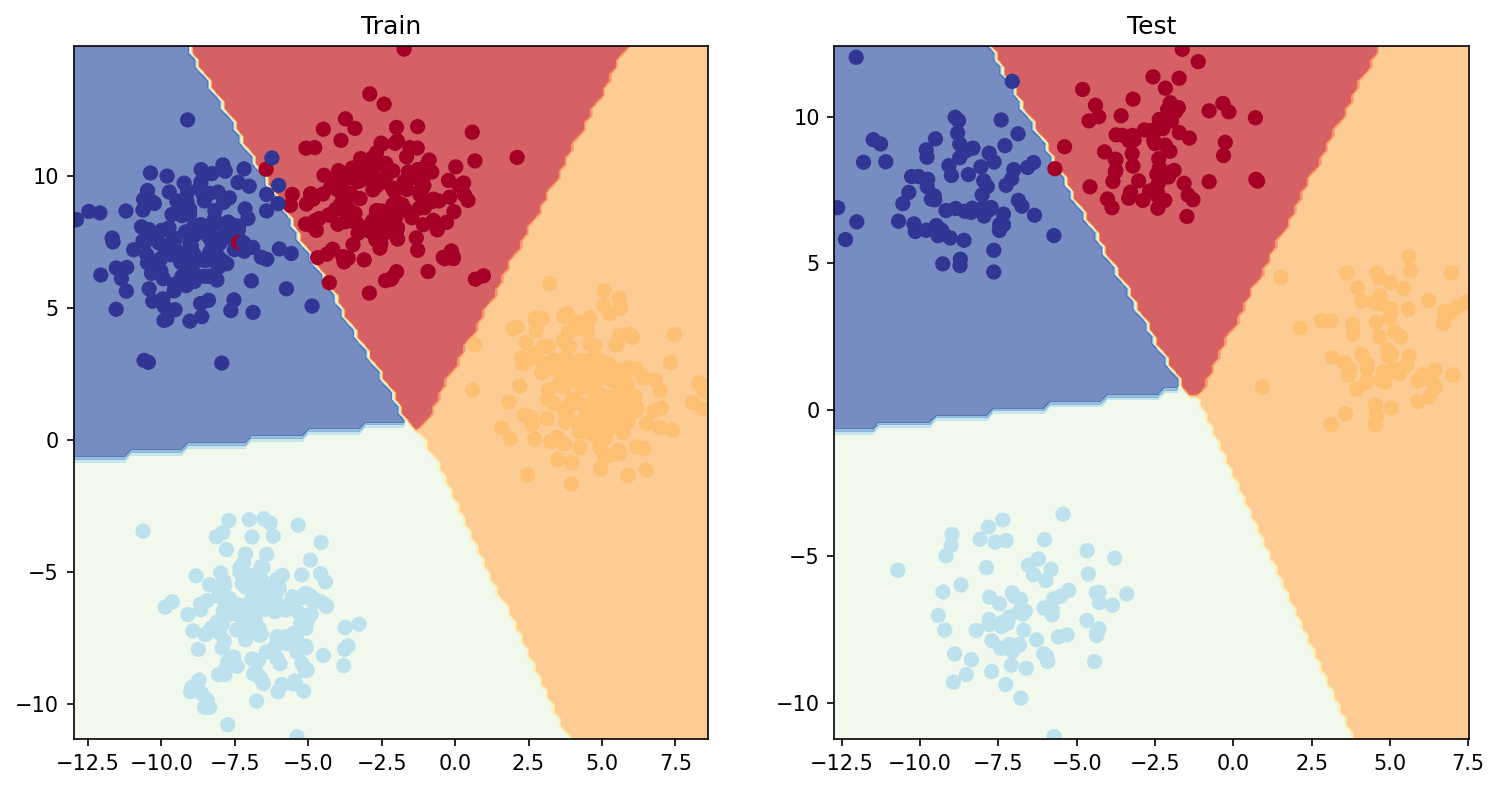

In [26]:
plt.figure(figsize=(12, 6), dpi=150)

plt.subplot(1, 2, 1)
plt.title("Train")

plot_decision_boundary(model, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")

plot_decision_boundary(model, X_test, y_test)

plt.show()

### -> Check the difference when we use ReLU as our activation function.

<br>
<br>

<br>
<br>

# (Appendix 1) Various classification evaluation metrics

<br>

#### (Official) **TorchMetrics** - All metrics @ https://torchmetrics.readthedocs.io/en/stable/all-metrics.html

#### (Official) TorchMetrics - **Classification metrics** @ https://torchmetrics.readthedocs.io/en/stable/pages/classification.html

In [27]:
!pip install torchmetrics # 0.10.3

# "액세스가 거부되었습니다" 에러가 발생하거나 정상적으로 설치가 진행되지 않을 경우,
# cmd(명령프롬프트) 우클릭 & 관리자권한으로 실행 후,
# 느낌표를 제외한 명령어를 1줄씩 입력 & 실행하여 설치를 진행합니다.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 10.7 MB/s eta 0:00:0000:0100:01


In [28]:
from torchmetrics import Accuracy # Accuracy-score

In [38]:
# metric variable should be on the same device, too.
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device) # 특정한 디바이스"로"

In [39]:
torchmetrics_accuracy(y_predicted, y_test.to(device)) # predictions, target

tensor(0.9933, device='mps:0')

In [40]:
torchmetrics_accuracy(y_predicted, y_test.to(device)).item() # Scalar tensor -> Plain number

0.9933333396911621

In [ ]:
from torchmetrics import # press "Tab" & browse other metrics

In [ ]:
# Accuracy         : torchmetrics.Accuracy() or sklearn.metrics.accuracy_score()
# Precision        : torchmetrics.Precision() or sklearn.metrics.precision_score()
# Recall           : torchmetrics.Recall() or sklearn.metrics.recall_score()
# F1-score         : torchmetrics.F1Score() or sklearn.metrics.f1_score()
# Confusion matrix : torchmetrics.ConfusionMatrix() or sklearn.metrics.plot_confusion_matrix()

In [41]:
from torchmetrics import Accuracy, Precision, Recall, F1Score, ConfusionMatrix 

In [43]:
for metric in [ Accuracy, Precision, Recall, F1Score]:
    
    metric = metric(task='multiclass', num_classes=4).to(device)
    result = metric(y_predicted, y_test.to(device)).item() # Scalar tensor -> Plain number
    
    print(metric.__str__()[:-2], "\n:", result)

MulticlassAccuracy 
: 0.9933333396911621
MulticlassPrecision 
: 0.9933333396911621
MulticlassRecall 
: 0.9933333396911621
MulticlassF1Score 
: 0.9933333396911621


In [ ]:
# metric.__str__()

In [45]:
confusion_matrix = ConfusionMatrix(task='multiclass', num_classes=4).to(device) # We should set "the number of classes" to use the torchmetrics.ConfusionMatrix

result = confusion_matrix(y_predicted, y_test.to(device))

result #.numpy()

tensor([[74,  0,  0,  1],
        [ 0, 69,  0,  0],
        [ 0,  0, 79,  0],
        [ 1,  0,  0, 76]], device='mps:0')

<br>
<br>

# (Appendix 2) When we need the "Non-linearity"

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn # PyTorch's building blocks for neural networks

from torchmetrics import Accuracy # Accuracy-score

<br>

### 1) Preparing the dataset

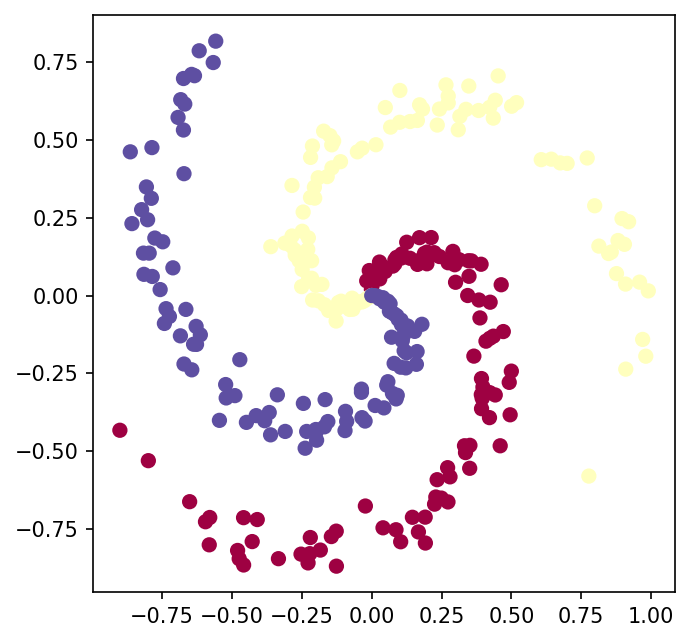

In [87]:
# Code for creating a spiral dataset from CS231n @ https://cs231n.github.io/neural-networks-case-study/

N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes

X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels

for j in range(K):
    ix = range(N*j, N*(j+1))
    r = np.linspace(0.0, 1, N) # radius
    t = np.linspace(j*4, (j+1)*4, N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
    y[ix] = j
    
plt.figure(figsize=(5, 5), dpi=150)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [88]:
print(X[:5], '\n\n', y[:5])

[[ 0.          0.        ]
 [-0.00046053  0.01009051]
 [-0.00122692  0.02016473]
 [ 0.00076901  0.03029327]
 [ 0.00157046  0.04037351]] 

 [0 0 0 0 0]


In [89]:
# Numpy array -> PyTorch tensor

X = torch.from_numpy(X).type(torch.float) # Numpy"로부터" & torch.float == float32
y = torch.from_numpy(y).type(torch.LongTensor) # IntTensor == Int32 vs LongTensor == Int64

print(X[:5], '\n\n', y[:5])

tensor([[ 0.0000,  0.0000],
        [-0.0005,  0.0101],
        [-0.0012,  0.0202],
        [ 0.0008,  0.0303],
        [ 0.0016,  0.0404]]) 

 tensor([0, 0, 0, 0, 0])


In [90]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=42) 

<br>

### 2) Build the model

In [91]:
device = "mps" if torch.backends.mps.is_available() else "cpu" # "cuda"가 사용 가능하다면(if it "is available")

device

'mps'

In [92]:
class ModelSpiralMLP(nn.Module):
    
    
    def __init__(self, num_features, num_classes, num_nodes=16):
        
        super().__init__()
        
        self.sequential_stack = nn.Sequential(
            
            nn.Linear(in_features=num_features, out_features=num_nodes),
            nn.ReLU(), # apply as needed (Non-linearity)
            
            nn.Linear(in_features=num_nodes, out_features=num_nodes),
            nn.ReLU(), # apply as needed (Non-linearity)
            
            nn.Linear(in_features=num_nodes, out_features=num_classes),
            # We don't need to use nn.Softmax() (check the following source codes)
        )
    
    def forward(self, x):
        
        return self.sequential_stack(x)

<br>

### 3) Train the model

In [93]:
torch.manual_seed(42) # "Manually" set the "seed" for [ nn.Parameter ]

model = ModelSpiralMLP(num_features=2, # X.shape[1]
                       num_classes=3,  # len(y.unique())
                       num_nodes=16).to(device)

loss_fn = nn.CrossEntropyLoss() # Softmax + CrossEntropy (built-in Softmax)

optimizer = torch.optim.Adam(params=model.parameters(),  # "parameters" to optimize (apply gradient descent)
                             lr=0.01) # "l"earning "r"ate 

metric_accuracy = Accuracy(task='multiclass', num_classes=3).to(device)

In [94]:
torch.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)


for epoch in range(100):
    
    # 모델을 training mode로 설정 (default state)
    model.train()

    # 1. (x 데이터를 모델에 넣고) 순방향 계산 진행 (forward pass)
    logits = model(X_train)
    y_predicted = torch.softmax(logits, dim=1).argmax(dim=1) # logits -> (softmax) predicted probs -> (argmax) predicted class nums

    # 2. Training cost 계산 (Cost function 계산)
    loss_train = loss_fn(logits, y_train) # <- nn.CrossEntropyLoss() : built-in Softmax

    # 3. Optimizer 내부의 이전 gradient 값 초기화 (Make "grad" to "zero")
    optimizer.zero_grad()

    # 4. Back-propagation ("Backward" propagation)
    loss_train.backward()

    # 5. Gradient descent 진행 (Take a "step" to update parameters)
    optimizer.step()

    
    # 모델을 evaluation mode로 설정
    model.eval()
    
    with torch.inference_mode(): # Set "inference mode"
        
        # (x 데이터를 모델에 넣고) 순방향 계산 진행 (forward pass)
        logits_test = model(X_test)
        y_predicted_test = torch.softmax(logits_test, dim=1).argmax(dim=1)
        
        # Test cost 계산
        loss_test = loss_fn(logits_test, y_test)
        

    acc_train = metric_accuracy(y_predicted, y_train) 
    acc_test  = metric_accuracy(y_predicted_test, y_test)
    
    
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss_train:.5f}, Acc: {acc_train:.2f}% | Test loss: {loss_test:.5f}, Test acc: {acc_test:.2f}%")

Epoch: 0 | Loss: 1.12692, Acc: 0.35% | Test loss: 1.14463, Test acc: 0.30%
Epoch: 10 | Loss: 1.01590, Acc: 0.55% | Test loss: 1.02342, Test acc: 0.52%
Epoch: 20 | Loss: 0.84888, Acc: 0.58% | Test loss: 0.86434, Test acc: 0.52%
Epoch: 30 | Loss: 0.68808, Acc: 0.59% | Test loss: 0.72377, Test acc: 0.54%
Epoch: 40 | Loss: 0.59228, Acc: 0.61% | Test loss: 0.64739, Test acc: 0.60%
Epoch: 50 | Loss: 0.49943, Acc: 0.72% | Test loss: 0.55209, Test acc: 0.71%
Epoch: 60 | Loss: 0.40631, Acc: 0.80% | Test loss: 0.44192, Test acc: 0.80%
Epoch: 70 | Loss: 0.31776, Acc: 0.88% | Test loss: 0.35372, Test acc: 0.86%
Epoch: 80 | Loss: 0.24489, Acc: 0.91% | Test loss: 0.29154, Test acc: 0.90%
Epoch: 90 | Loss: 0.18841, Acc: 0.94% | Test loss: 0.25051, Test acc: 0.93%


<br>

### 4) Evaluate the model

In [95]:
# 1. 모델을 evaluation mode로 설정
model.eval()

# 2. inference mode 세팅
with torch.inference_mode():
    
    # 3. 모델과 데이터는 동일한 디바이스 위에 있어야 함 (GPU or CPU)
    logits = model(X_test.to(device))
    y_predicted_test = torch.softmax(logits, dim=1).argmax(dim=1) #  logits -> predicted probs -> predicted class nums

acc_test  = metric_accuracy(y_predicted_test, y_test)

print('Test accuracy : {} %'.format(acc_test))

Test accuracy : 0.9666666388511658 %


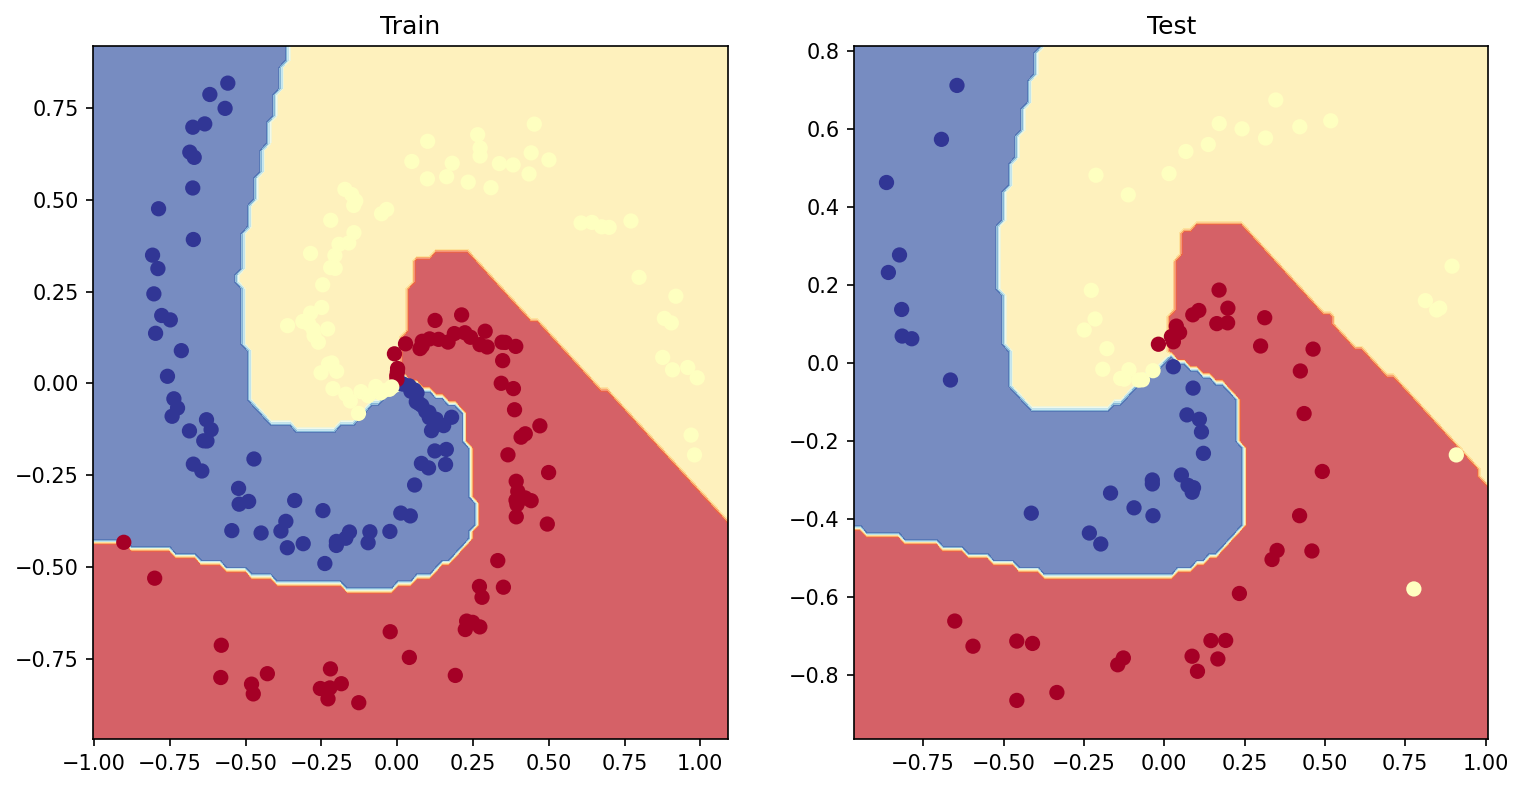

In [96]:
plt.figure(figsize=(12, 6), dpi=150)

plt.subplot(1, 2, 1)
plt.title("Train")

plot_decision_boundary(model, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")

plot_decision_boundary(model, X_test, y_test)

plt.show()

### -> Check the difference when we use ReLU as our activation function.

<br>
<br>